In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger as TensorBoardLogger
import tensorboard


import numpy as np
from lstm_model import BasicLSTM
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, r'C:\Users\Spenc\Documents\GitHub\itcs-8156\utils')
sys.path.insert(1, r'D:\Documents\GitHub\itcs-8156\utils')

from preprocessing import (market_prepro,
                           lstm_timeseries_feat_and_targ,
                           
)

In [3]:

def makepred(model, dataset):
    y = []
    t = []
    for ii in dataset:
        feat, lab = ii

        y.append(model.forward(feat).detach().numpy()[0])
        t.append(lab.numpy()[0])


    return y, t

def scatter_results(Y,T,title):
    plt.figure(figsize=(9,9))
    plt.scatter(Y,T)
    plt.xlabel('Model Prediction')
    plt.ylabel('True Value')
    plt.title(title)

In [10]:
# st = "Stocks"
st = "ETFs"

#Input stock name
sn = "aadr" 
f = r'G:\My Drive\School\UNCC\P.h.D\Coursework\2023 - SPRING\ITCS 8156 - Machine Learning\Project\archive'
f = r'D:\Desktop\College Spring 2023\machineLearning\project\coding\data'

X_train, X_test, T_train, T_test = market_prepro(f,st,sn,False,splitdata=True, stdzr='minmax')

print(X_train.shape)
print(T_train.shape)
# X,T = market_prepro(f,st,sn,False,splitdata=False)

actfn1 = ['Sigmoid', 'arcsinh', 'Mish', 'ReLU',  'SELU', 'LeakyReLU']
actfn2 = ['tanh', 'tanh', 'Sigmoid', 'Sigmoid', 'Sigmoid', 'ELU']

test_days = [2, 3, 5, 7, 10, 15, 20]
results_daysweep = []

for i in range(len(actfn1)):

    act1fn1=actfn1[i]
    act2fn2=actfn2[i]

    for j in range(len(test_days)):
        #number of days as features
        day_feat = test_days[j]

        #number of days to use as features
        day_targ = 1
        day_targ = day_targ - 1

        # dl_train, ds_train = lstm_timeseries_feat_and_targ(X_train[['Open','Low']], T_train, 4, 1,None)
        # dl_test, ds_test = lstm_timeseries_feat_and_targ(X_test[['Open','Low']], T_test, 4, 1,  None)

        dl_train, ds_train = lstm_timeseries_feat_and_targ(X_train, T_train, day_feat, day_targ, [ 'Year', 'Month' ,'Day_date', 'Day'])
        dl_test, ds_test = lstm_timeseries_feat_and_targ(X_test, T_test, day_feat, day_targ, [ 'Year', 'Month' ,'Day_date', 'Day'])

        mdl_stock = BasicLSTM(num_feat=7, num_hiddens=1, num_out=1, lr=0.01, actfn1=act1fn1, actfn2=act2fn2)
        mdl_stock.forward(ds_train[0][0])

        logger = TensorBoardLogger("lightning_logs", name="market")
        trainer = pl.Trainer(max_epochs=5,logger=logger) # with default learning rate, 0.001 (this tiny learning rate makes learning slow)
        trainer.fit(mdl_stock, train_dataloaders=dl_train)
        trainer.test(mdl_stock,dataloaders=dl_test)
        torch.save(mdl_stock, act1fn1+act2fn2+str(day_feat))

        y_test, t_test = mdl_stock.makepred(ds_test)
        y_train, t_train = mdl_stock.makepred(ds_train)

        train_score = r2_score(t_train, y_train)
        test_score = r2_score(t_test, y_test)

        add_res_sweep = [act1fn1, act2fn2, day_feat, train_score, test_score]

        results_daysweep.append(add_res_sweep)

torch.save(results_daysweep, 'Day Input Sweep Results')

(1044, 11)
(1044,)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0013433656330588213
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.00644518620635937
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.007444368910197197
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch      0.00015483628380518966
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.01862642460520937
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch      0.00038313629402755514
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0077110282405583085
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0008451277097857724
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.004056651446627798
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0041482170973156235
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.004558206449330866
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.005478497074648738
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0006723436459809906
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.005535691073506294
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.030859363267924635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.030378908891566216
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.03290062332772632
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.03146446456325975
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.030935306186322533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.03179113013353598
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.03175486604206621
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.030235024987514528
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.030223340488039433
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.03072910037568694
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.03081319762613368
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.030644491201951448
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.03188058220928289
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.00185325407382758
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.002375181046739749
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0018808463399310731
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0033411443283827722
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.06317828617838585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.17063710990232347
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.008585992179687647
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.3148155505180016
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.001538103365982075
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0019241129888897652
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0012400943467383433
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0014595642386933205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0006785387675754835
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.003126999982368206
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  r

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.001062964029993353
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Time to look at all the reults. we will sort by activation function and then number of days

In [46]:
results_daysweep= torch.load('Day Input Sweep Results')
sweep = pd.DataFrame(results_daysweep)
sweep.sort_values(by=[0,2],axis=0)
display(sweep.sort_values(by=[0,2],axis=0))

,0,1,2,3,4
35,LeakyReLU,ELU,2,0.995017,0.950982
36,LeakyReLU,ELU,3,0.992510,0.938661
37,LeakyReLU,ELU,5,0.992021,0.960438
38,LeakyReLU,ELU,7,0.994722,0.953390
39,LeakyReLU,ELU,10,0.993883,0.978267
40,LeakyReLU,ELU,15,0.928454,0.899531
41,LeakyReLU,ELU,20,0.996179,0.965880
14,Mish,Sigmoid,2,0.984580,0.016541
15,Mish,Sigmoid,3,0.985465,0.031540
16,Mish,Sigmoid,5,0.973106,-0.049622


### Lets drop the functions that are really bad

In [51]:
sweep_drop = sweep.sort_values(by=[0,2],axis=0)

sweep_drop = sweep_drop[sweep_drop[4] > 0.90]

display(sweep_drop)

,0,1,2,3,4
35,LeakyReLU,ELU,2,0.995017,0.950982
36,LeakyReLU,ELU,3,0.992510,0.938661
37,LeakyReLU,ELU,5,0.992021,0.960438
38,LeakyReLU,ELU,7,0.994722,0.953390
39,LeakyReLU,ELU,10,0.993883,0.978267
41,LeakyReLU,ELU,20,0.996179,0.965880
27,ReLU,Sigmoid,20,0.981189,0.940512
28,SELU,Sigmoid,2,0.978058,0.924305
29,SELU,Sigmoid,3,0.976224,0.940040
0,Sigmoid,tanh,2,0.991585,0.957188


### Now that we have dropped the worst performing activations lets look at the best performers for each day

In [55]:
display(sweep_drop.sort_values(by=[2,4],ascending=[True, False]))

,0,1,2,3,4
7,arcsinh,tanh,2,0.996153,0.973067
0,Sigmoid,tanh,2,0.991585,0.957188
35,LeakyReLU,ELU,2,0.995017,0.950982
28,SELU,Sigmoid,2,0.978058,0.924305
29,SELU,Sigmoid,3,0.976224,0.940040
36,LeakyReLU,ELU,3,0.992510,0.938661
37,LeakyReLU,ELU,5,0.992021,0.960438
3,Sigmoid,tanh,7,0.974489,0.995055
38,LeakyReLU,ELU,7,0.994722,0.953390
39,LeakyReLU,ELU,10,0.993883,0.978267


Text(0, 0.5, 'r2 score')

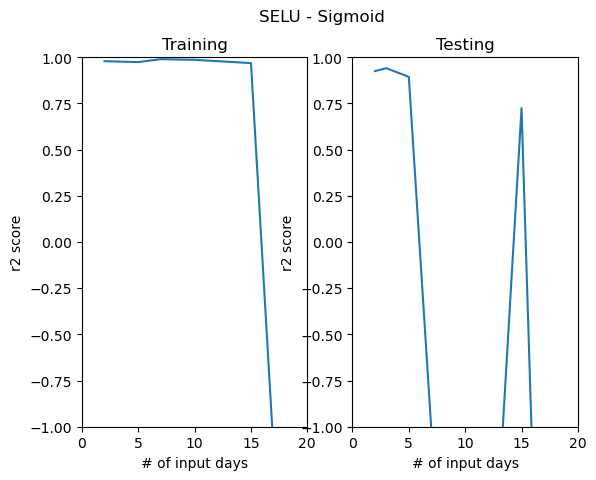

In [12]:
sweep_res=pd.DataFrame(results_daysweep)
train_sweep = sweep_res.where(sweep_res[0] == 'SELU').dropna()
plt.figure()
plt.suptitle('SELU - Sigmoid')
plt.subplot(121)
plt.plot(train_sweep[2], train_sweep[3])
plt.xlim([0,20])
plt.ylim([-1,1])
plt.title('Training')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

plt.subplot(122)
plt.plot(train_sweep[2], train_sweep[4])
plt.xlim([0,20])
plt.ylim([-1,1])
plt.title('Testing')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

Text(0, 0.5, 'r2 score')

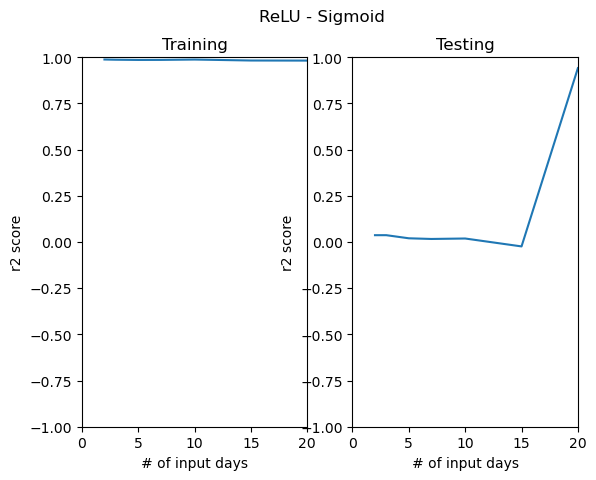

In [13]:
train_sweep = sweep_res.where(sweep_res[0] == 'ReLU').dropna()
plt.figure()
plt.suptitle('ReLU - Sigmoid')
plt.subplot(121)
plt.plot(train_sweep[2], train_sweep[3])
plt.xlim([0,20])
plt.ylim([-1,1])
plt.title('Training')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

plt.subplot(122)
plt.plot(train_sweep[2], train_sweep[4])
plt.xlim([0,20])
plt.ylim([-1,1])
plt.title('Testing')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

Text(0, 0.5, 'r2 score')

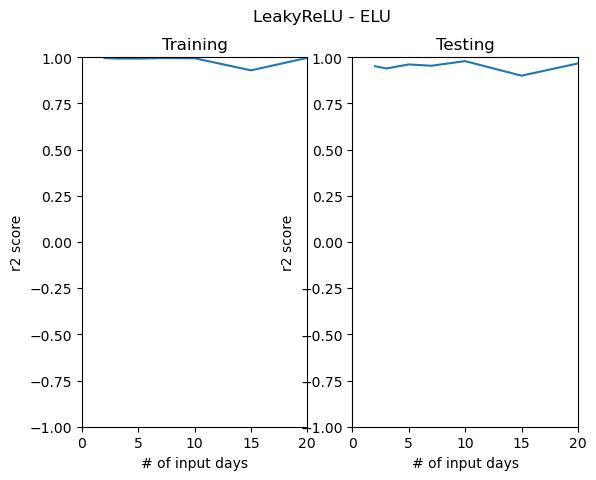

In [14]:
train_sweep = sweep_res.where(sweep_res[0] == 'LeakyReLU').dropna()
plt.figure()
plt.suptitle('LeakyReLU - ELU')
plt.subplot(121)
plt.plot(train_sweep[2], train_sweep[3])
plt.xlim([0,20])
plt.ylim([-1,1])
plt.title('Training')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

plt.subplot(122)
plt.plot(train_sweep[2], train_sweep[4])
plt.xlim([0,20])
plt.ylim([-1,1])
plt.title('Testing')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

Text(0, 0.5, 'r2 score')

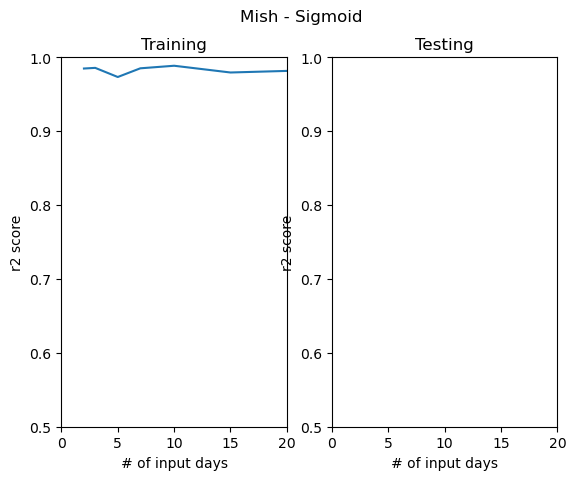

In [15]:
train_sweep = sweep_res.where(sweep_res[0] == 'Mish').dropna()
plt.figure()
plt.suptitle('Mish - Sigmoid')
plt.subplot(121)
plt.plot(train_sweep[2], train_sweep[3])
plt.xlim([0,20])
plt.ylim([0.5,1])
plt.title('Training')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

plt.subplot(122)
plt.plot(train_sweep[2], train_sweep[4])
plt.xlim([0,20])
plt.ylim([0.5,1])
plt.title('Testing')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

Text(0, 0.5, 'r2 score')

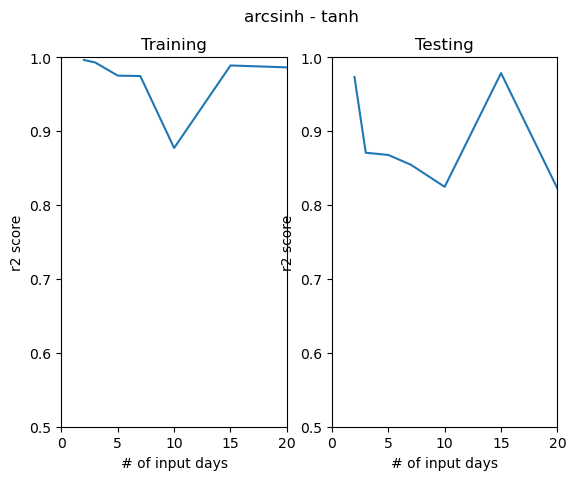

In [16]:
train_sweep = sweep_res.where(sweep_res[0] == 'arcsinh').dropna()
plt.figure()
plt.suptitle('arcsinh - tanh')
plt.subplot(121)
plt.plot(train_sweep[2], train_sweep[3])
plt.xlim([0,20])
plt.ylim([0.5,1])
plt.title('Training')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

plt.subplot(122)
plt.plot(train_sweep[2], train_sweep[4])
plt.xlim([0,20])
plt.ylim([0.5,1])
plt.title('Testing')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

C:\Users\patbo\AppData\Local\Temp\ipykernel_26232\3963620977.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


Text(0, 0.5, 'r2 score')

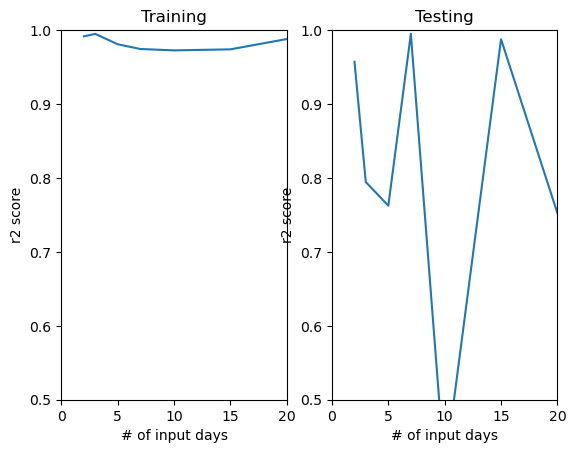

In [17]:
train_sweep = sweep_res.where(sweep_res[0] == 'Sigmoid').dropna()
plt.figure()
plt.title('Sigmoid - tanh or BASE LSTM')
plt.subplot(121)
plt.plot(train_sweep[2], train_sweep[3])
plt.xlim([0,20])
plt.ylim([0.5,1])
plt.title('Training')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

plt.subplot(122)
plt.plot(train_sweep[2], train_sweep[4])
plt.xlim([0,20])
plt.ylim([0.5,1])
plt.title('Testing')
plt.xlabel('# of input days')
plt.ylabel('r2 score')